#### This is a [jupyter](https://jupyter.org/) notebook that contains text, equations, images and executable code in one document.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import ipywidgets as ipw
%matplotlib inline
sy.init_printing(use_latex=True)

# Finite Elements: Global Matrices for Pipe Example
In this example, we will use the one-dimensional linear elements to calculate the sound field inside a pipe. First we take a look a the problem at hand. The pipe has a length $l$, and the fluid inside the pipe has a speed of sound $c$. The domain where the sound field is of interest is one-dimensional and it is partitioned into $N$ elements. The partition does not need to be equidistant. Therefore we allow a certain randomness to generate the FE mesh. The function _generate1D_ generates the node coordinates.

In [2]:
def generate1D(N, l=1, randomness=0): 
    x = (np.ones(N+1)+np.random.normal(size=N+1)*randomness).cumsum()
    x -= x[0]
    return x*l/x[-1]

def plot_nodes(x):
    plt.plot(x,np.zeros_like(x),'o')
    for i,xi in enumerate(x):
        plt.text(xi,x[-1]/20,'%i' % i,horizontalalignment='center')
    plt.axis('equal')
    plt.axis('off')

@ipw.interact(N=10,rn=0.0)    
def plot_nodes_interact(N,rn):
    plt.figure(1,(10,2))
    plot_nodes(generate1D(N,1.0,rn))    

interactive(children=(IntSlider(value=10, description='N', max=30, min=-10), FloatSlider(value=0.0, descriptio…

The $N$ elements each have two nodes. Because our example is so extremely simple, we can easily say which nodes belong to a certain element and which length the element has. We store this information in three arrays. In a more practical application we would have decide about a clever way to handle this information, especially when different element types are used within one mesh.

In [3]:
def get_element_information(x):
    le = x[1:]-x[:-1]
    n1_index = np.arange(x.shape[0]-1)
    n2_index = n1_index+1
    return np.vstack((n1_index,n2_index)).T,le

# example with 10 finite elements
for nidx, le in zip(*get_element_information(generate1D(10,1.0,0.1))):
    print("element %i has nodes %s and length %.3f" % (nidx[0],nidx,le))

element 0 has nodes [0 1] and length 0.091
element 1 has nodes [1 2] and length 0.101
element 2 has nodes [2 3] and length 0.112
element 3 has nodes [3 4] and length 0.101
element 4 has nodes [4 5] and length 0.105
element 5 has nodes [5 6] and length 0.097
element 6 has nodes [6 7] and length 0.087
element 7 has nodes [7 8] and length 0.094
element 8 has nodes [8 9] and length 0.095
element 9 has nodes [ 9 10] and length 0.119


As this information is now available, we can compute all the element matrices. We know the entries of those from the derivation of the element mass matrix $\mathbf{M_{el}}$ and the element stiffness matrix $\mathbf{K_{el}}$.

In [4]:
def Kel(le):
    return np.array(((1,-1),(-1,1)))[np.newaxis]/le[:,np.newaxis,np.newaxis] # dimensions Nx2x2

def Mel(le, c=344):
    return np.array(((2,1),(1,2)))[np.newaxis]*le[:,np.newaxis,np.newaxis]/6/c**2 # dimensions Nx2x2

The global matrices $\mathbf K$ and $\mathbf M$ can now be assembled. The overall dimension of that matrices is $(N+1) \times (N+1)$. As it will turn out that these matrices have only few nonzero elements, sparse matrix structures will be used to store the matrices. The assembly process just add each element matrix to the rows and columns that correspond to the node numbers for the element. 

(<11x11 sparse matrix of type '<class 'numpy.float64'>'
 	with 31 stored elements in LInked List format>,
 <11x11 sparse matrix of type '<class 'numpy.float64'>'
 	with 31 stored elements in LInked List format>)

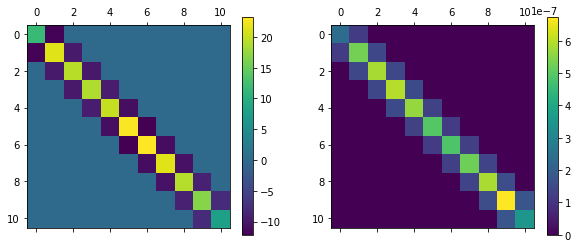

In [5]:
import scipy.sparse as sp
def assemble_global(X):
    nidx,le = X
    N = le.shape[0]
    K = sp.lil_matrix((N+1,N+1),dtype='float')
    M = sp.lil_matrix((N+1,N+1),dtype='float')
    Ke = Kel(le)
    Me = Mel(le)
    for i in range(N):
        K[np.ix_(nidx[i],nidx[i])] += Ke[i]
        M[np.ix_(nidx[i],nidx[i])] += Me[i]
    return K,M

# example with 10 finite elements
K,M = assemble_global(get_element_information(generate1D(10,1.0,0.1)))        
fig, axarr = plt.subplots(1,2,figsize=(10,4))    
msk = axarr[0].matshow(K.toarray()) 
fig.colorbar(msk,ax=axarr[0])
msm = axarr[1].matshow(M.toarray()) 
fig.colorbar(msm,ax=axarr[1])
K,M    

Note, that both matrices are sparse and banded. The latter is not necessarily the case if the FE model has a different topology. However, the matrices columns and/or rows can be switched to get matrix where the non-zero elements concentrate around the main diagonal (form a band). This property can be of advantage for the numerical solution of the equations that arise in FE analysis.

#### Modal extraction (numerical modal  analysis)

Now that we have the global stiffness and mass matrices, we can compute the eigenfrequencies of the pipe. We assume both ends of the pipe to be rigidly terminated. Thus, all elements of the rhs vector are zero:
\begin{equation}
\mathbf{K}\mathbf{p}-
\omega^2 \mathbf{M} \mathbf{p} = 0
\end{equation}
This is equivalent to the (generalized) eigenvalue problem
\begin{equation}
\mathbf{K}\mathbf{p} =
\omega^2 \mathbf{M} \mathbf{p},
\end{equation}
where $\omega^2$ is the eigenvalue and $\mathbf p$ the eigenvector. Generally we can expect to get up to $N+1$ pairs of eigenvalue and eigenvector.

Let us now see the result for one case with $N=10$ identical elements and $l=1$m. The speed of sound is assumed to be 344 m/s.

In [6]:
from scipy.sparse.linalg import eigsh
from scipy.linalg import eig
x = generate1D(10,1.0,0.0)
K,M = assemble_global(get_element_information(x))
om2, evec = eigsh(K,M=M,sigma=1,k=8)
freq =(om2**0.5)/2/np.pi
print("eigenfrequencies:", freq)

eigenfrequencies: [6.73236948e-06 1.72708167e+02 3.49682886e+02 5.35244046e+02
 7.33625330e+02 9.48285700e+02 1.17993265e+03 1.42200037e+03]


The correct values can be computed from
\begin{equation}
f_n = n\frac{c}{2l}\qquad p_n(x)=p_{0n}\cos(\frac{\pi nx}{l})
\end{equation}
and used for comparison with the values from FEM.

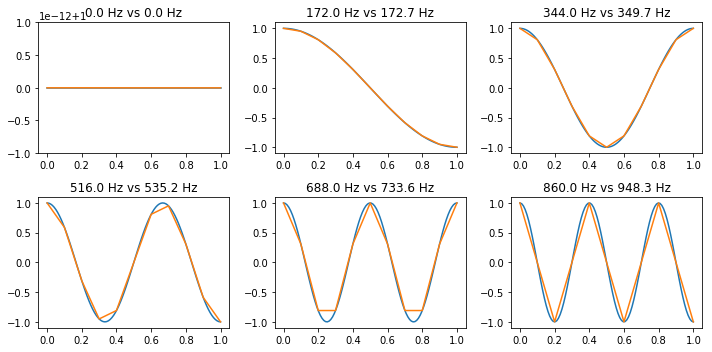

In [7]:
# N correct results
def correct(N,l,c=344):
    xn = np.linspace(0,l,100) # to discretize the correct result
    pn = np.cos(np.pi*xn[:,np.newaxis]/l*np.arange(N)[np.newaxis])
    fn = np.arange(N)*c/2/l
    return fn, pn.T, xn
# compare first six results
fn,pn,xn = correct(6,1)
pfem  = evec.T
fig, axarr = plt.subplots(2,3,figsize=(10,5))
for i in range(6):
    axarr.flat[i].plot(xn,pn[i])
    axarr.flat[i].set_title('%.1f Hz vs %.1f Hz' % (fn[i],freq[i]))
    axarr.flat[i].plot(x,pfem[i]/pfem[i,0])    
plt.tight_layout()

Obviously the error increases with frequency. As the wavelength decreases with frequency and the element size is the same for all frequencies, it is also true that the error becomes small if we have more elements per wavelength. If we define the error for the eigenfrequency as
\begin{equation}
\epsilon = \frac{\left|f_{FEM}-f_n \right|}{f_n}
\end{equation}
we can plot this error over the number of elements per wavelength. This time we use 100 elements to get more data that we can plot.

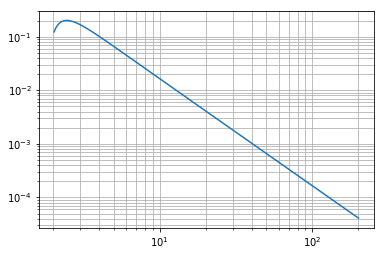

In [8]:
x = generate1D(100,1.0,0.0)
K,M = assemble_global(get_element_information(x))
om2, evec = eigsh(K,M=M,sigma=1,k=99)
freq =(om2[1:]**0.5)/2/np.pi # to avoid zero freq.
fn = np.arange(1,99)*172
lambda_ = 344/fn
el_per_lambda = lambda_*100/1.0
error = np.abs(freq-fn)/fn
plt.loglog(el_per_lambda,error)
plt.grid(True,'both')

From about six elements per wavelength, the error becomes less than 5%. Therefore, a rule of thumb, that is often used, says that elements should not be larger than 1/6 of the wavelength.

If you are interested, you could try and repeat the last three steps but this time with elements of somewhat different size, e.g. setting the randomness in _generate1D_ to 0.1 .

#### Harmonic analysis - direct frequency response
Now we assume that on one end of tube, a loudspeaker is mounted that excites the fluid with a harmonic acceleration that has a constant magnitude. This means that the first entry in the right hand side $\mathbf F$ of the equation is nonzero and the equation can be solved for any given frequency $\omega$:
\begin{equation}
\left(\mathbf{K}-
\omega^2 \mathbf{M}\right) \mathbf{p} = \mathbf{F}
\end{equation}
In our example, we solve for frequencies from 100 Hz to 800 Hz in steps of 5 Hz.

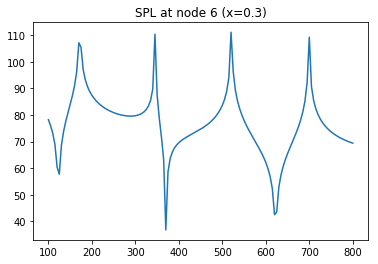

In [9]:
from scipy.sparse.linalg import spsolve
x = generate1D(20,1.0,0.0) # 20 elements
K,M = assemble_global(get_element_information(x))
pl = [] #list of sound pressures to be filled with the results
F = np.zeros_like(x)
F[0] = 1.0
freqs = np.arange(100,801,5)
for f in freqs: # loop over all frequencies
    A = K-(2*np.pi*f)**2 * M
    p = spsolve(A,F)
    pl.append(p[6])# store results at node 6
pl = np.asarray(pl)
plt.plot(freqs,20*np.log10(np.abs(pl)/2e-5))
plt.title('SPL at node 6 (x=%.1f)' % x[6]);

#### License

This notebook is an [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text and the images are licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), and any code under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Ennes Sarradj, Numerical Acoustics: Finite Elements: Global Matrices Pipe Example, 2019.